In [1]:
# Import necessary libraries
import gempy as gp
import gempy_viewer as gpv
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import os
import verde as vd
import gemgis as gg
import pyvista as pv
from disba import PhaseDispersion,EigenFunction,PhaseSensitivity

import time, array, random

from deap import base, creator, tools, algorithms
from IPython.display import display, HTML


from CODES.modeling import create_seismic_model,calculate_parameters,calculate_parameters_from_vs
from CODES.pyvista_create_gif import pyvista_create_gif

Setting Backend To: AvailableBackends.numpy


# Inputs and outputs

In [2]:
folder_model_name = 'MCP1'

### Directory for saving model and other related stuffs: 

In [3]:
data_path = 'OUTPUT/'+folder_model_name+'/DATA/'

### Directory for saving figures: 

In [4]:
figures_path = 'OUTPUT/'+folder_model_name+'/FIGURES/'

In [5]:
# Creating directories: 
os.makedirs(data_path,exist_ok=True)
os.makedirs(figures_path,exist_ok=True)

----

# The model will be created by the **GemPy** (https://www.gempy.org/)
### Completely free and open-source, Python-based project for generating 3D structural geological models. 
### Utilizing an implicit modeling approach, it enables the creation of complex combinations 
### of stratigraphical and structural features, including folds, faults, and unconformities. 

The core algorithm of GemPy is based on a universal cokriging interpolation method devised by Lajaunie et al. (1997) and extended by Calcagno et al. (2008). Its implicit nature allows the user to automatically generate complex 3D structural geological models through the interpolation of: (1) surface contact points (3D coordinates of points marking the boundaries between different features, such as layer interfaces, fault planes, unconformities), and (2) orientation measurements (orientations of the poles perpendicular to the dipping of surfaces at any point in the 3D space).

## Input parameters for creating the model:
The 3D model will be developed based on the 2D grid and the specified number of layers—in this case, three stacked horizontal layers over a half-space.

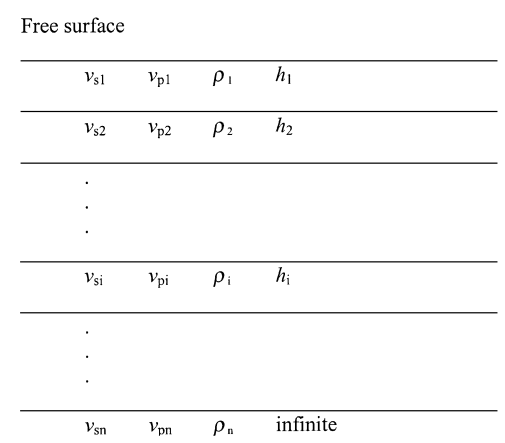

# **Examples of models**: 

Four different models were adopted to represent soil compaction in terms of density.  
1. The model without compaction (**MWC**) was used as a reference, presenting the normal density variation in the layers.
2. The **MCP1** model simulated compaction in the first layer, characterized by a higher of this layer.
3. The **MCP2-1** model considered compaction in the second layer with lateral density variation,
4. the **MCP2-2** model represented compaction in the second layer without lateral variation.

This approach allowed exploring different soil compaction scenarios and analyzing how these configurations impact the dispersion of surface waves, contributing to the identification and detailed characterization of compaction in agricultural soils. 

In [6]:
#    MWC
#    depth_ranges = [(-0.3, -0.5), (-0.8, -1.0), (-1.3, -1.5)] # meters
#    density_ranges = [(1.1, 1.2), (1.3, 1.4), (1.5, 1.7)] # g/cm³

In [7]:
#    MCP1
#    depth_ranges = [(-0.3, -0.5), (-0.8, -1.0), (-1.3, -1.5)] # meters
#    density_ranges = [(1.6, 1.7), (1.2, 1.3), (1.4, 1.5)] # g/cm³

In [8]:
#    MCP2-1
#    depth_ranges = [(-0.3, -0.5), (-0.8, -1.0), (-1.3, -1.5)] # meters
#    density_ranges = [(1.1, 1.2), (1.5, 1.7), (1.3, 1.4)] # g/cm³

In [9]:
#    MCP2-2
#    depth_ranges = [(-0.4, -0.4), (-0.9, -0.9), (-1.5, -1.5)] # meters
#    density_ranges = [(1.1, 1.2), (1.5, 1.7), (1.3, 1.4)] # g/cm³

### Layers of the Model:
- Number of layers: 3 horizontal layers
- Layer depths: Randomly selected from a predefined list of tuples

In [10]:
num_layers = 3
depth_ranges = [(-0.3, -0.5), (-0.8, -1.0), (-1.3, -1.5)] # meters
density_ranges = [(1.6, 1.7), (1.2, 1.3), (1.4, 1.5)] # g/cm³

-------------

### Grid Parameters:

As the layers are horizontal, there is no needed to over sampling.

- Profile length: 100 meters
- Node spacing: 25 meters

In [11]:
spacing = 25

west, east, south, north = 0, 100, 0, 100
region = (west, east, south, north)

# create the grid coordinates
X,Y = vd.grid_coordinates(region=region, spacing=spacing)

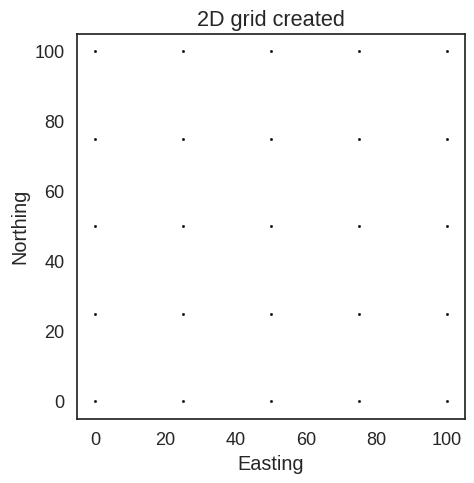

In [12]:
plt.figure(figsize=(5, 5))
ax = plt.subplot(111)
ax.scatter(X,Y,s=10,c='k',marker='.')
ax.set_title('2D grid created')
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.savefig(figures_path+'grid.png')

---------------

In [13]:
model = create_seismic_model(depth_ranges=depth_ranges,density_ranges=density_ranges,num_layers=num_layers,xi=X,yj=Y)

### Ploting 2D profile created:

In [14]:
density_grid = np.concatenate(model['densities'])
depth_grid = np.concatenate(model['depths'])

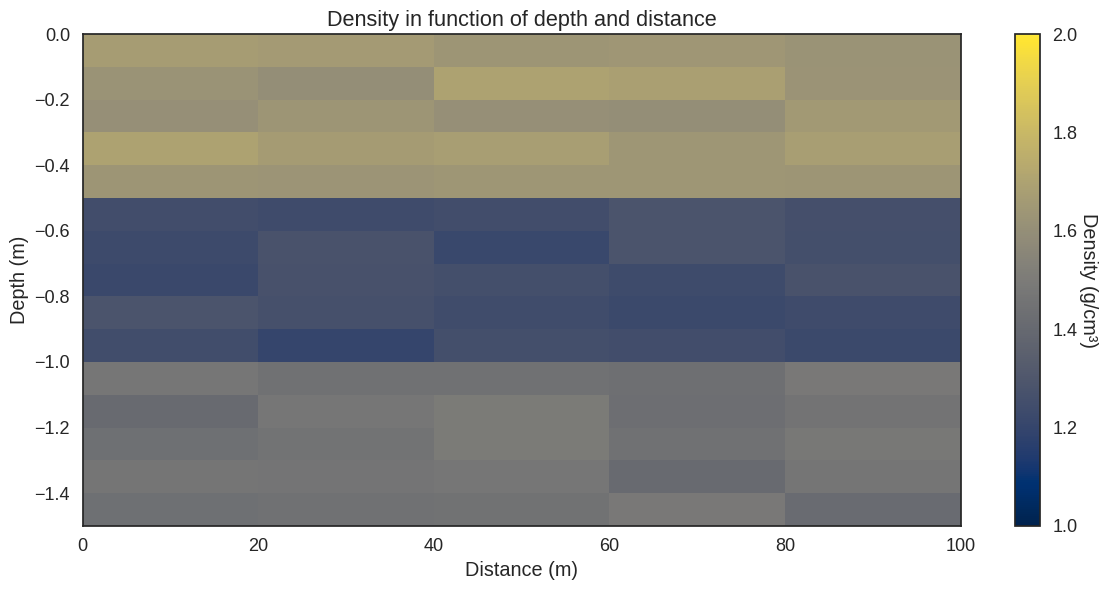

In [15]:
# Plotar o perfil de densidade ajustado
fig, ax = plt.subplots(figsize=(12, 6))
cmap = plt.get_cmap("cividis")
norm = mcolors.Normalize(vmin=1.0, vmax=2.0)
extent = [0, 100, -1.5, 0]
cax = ax.imshow(density_grid, extent=extent, origin='upper', cmap=cmap, aspect='auto', norm=norm)

# Adicionar barra de cores
cbar = fig.colorbar(cax)
cbar.set_label('Density (g/cm³)', rotation=270, labelpad=15)

# Configurações do gráfico
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Depth (m)')
ax.set_title('Density in function of depth and distance')

# Ajustar layout e salvar o gráfico
plt.tight_layout()
plt.savefig(figures_path+'profile_density.png', dpi=300)
plt.show()

# Creating a dataframe with information about the 3-layers soil profile
# Adding depth values to each point of the created 2D grid

This information is important to configure the GemPy model object, including defining structural groups and configuring their properties. 

This is a crucial step in setting up the structural framework of the geological model.

#### Creating files for ImporterHelper (https://docs.gempy.org/Helper%20Classes/gempy.core.data.ImporterHelper.html#gempy.core.data.ImporterHelper):
- **points.csv**

Data child with specific methods to manipulate interface data. It is initialize without arguments to giveflexibility to the origin of the data.

In [16]:
lst_soils = []
for l in range(num_layers):
    for k in range(len(model['xi'][l].ravel())):
            lst_soils.append({'X':model['xi'][l].ravel()[k], 'Y':model['yj'][l].ravel()[k], 'Z':model['depths'][l].ravel()[k], 'formation':model['formation'][l]})

In [17]:
soils_df = pd.DataFrame.from_dict(data=lst_soils)

In [18]:
soils_df

,X,Y,Z,formation
0,0.00,0.00,-0.41,soil1
1,25.00,0.00,-0.50,soil1
2,50.00,0.00,-0.47,soil1
3,75.00,0.00,-0.49,soil1
4,100.00,0.00,-0.36,soil1
...,...,...,...,...
70,0.00,100.00,-1.46,soil3
71,25.00,100.00,-1.39,soil3
72,50.00,100.00,-1.45,soil3
73,75.00,100.00,-1.43,soil3


In [19]:
if os.path.exists(data_path+'points.csv' ):
    os.remove(data_path+'points.csv')
soils_df.to_csv(data_path+'points.csv', header=soils_df.columns, index=None, sep=',', mode='a')

- **orientation.csv**

Data child with specific methods to manipulate orientation data. It is initialize without arguments to giveflexibility to the origin of the data.

In [20]:
lst_soils_orient = []
for l in range(num_layers):
    for tim in range(4):
        lst_soils_orient.append({'X':np.random.choice(model['xi'][l].ravel())*0.75, 'Y':np.random.choice(model['yj'][l].ravel())*0.75, 'Z':np.random.choice(model['depths'][l].ravel())*0.9, 'formation':model['formation'][l],'Azimuth':0,'Dip':0,'Polarity':1})
soils_orient_df = pd.DataFrame.from_dict(data=lst_soils_orient)

In [21]:
soils_orient_df

,X,Y,Z,formation,Azimuth,Dip,Polarity
0,56.25,75.00,-0.37,soil1,0,0,1
1,56.25,18.75,-0.36,soil1,0,0,1
2,0.00,37.50,-0.40,soil1,0,0,1
3,18.75,56.25,-0.40,soil1,0,0,1
4,18.75,75.00,-0.87,soil2,0,0,1
5,0.00,37.50,-0.78,soil2,0,0,1
6,18.75,75.00,-0.83,soil2,0,0,1
7,37.50,56.25,-0.72,soil2,0,0,1
8,75.00,18.75,-1.20,soil3,0,0,1
9,37.50,75.00,-1.18,soil3,0,0,1


In [22]:
if os.path.exists(data_path+'orientations.csv' ):
    os.remove(data_path+'orientations.csv')
soils_orient_df.to_csv(data_path+'orientations.csv', header=soils_orient_df.columns, index=None, sep=',', mode='a')

## Create instance of geomodel

**Parameters:**
- project_name (str, optional) – The name of the project. Defaults to ‘default_project’.
- extent (Union[List, np.ndarray], optional) – The 3D extent of the grid. Must be provided if resolution is specified. Defaults to None.
- resolution (Union[List, np.ndarray], optional) – The resolution of the grid. If None, an octree grid will be initialized. Defaults to None.
- refinement (int, optional) – The level of refinement for the octree grid. Defaults to 1.
- structural_frame (StructuralFrame, optional) – The structural frame of the GeoModel. Either this or importer_helper must be provided. Defaults to None.
- importer_helper (ImporterHelper, optional) – Helper object for importing structural elements. Either this or structural_frame must be provided. Defaults to None.

**Returns:**
The initialized GeoModel object.

class gempy.core.data.ImporterHelper(
- path_to_surface_points: str, 
- path_to_orientations: str)



In [23]:
grid_reso = 50
# Dados do modelo
extent = [0, 100, 0, 100, -2,0]  # [x_min, x_max, y_min, y_max, z_min, z_max]
resolution = [grid_reso,grid_reso,int(grid_reso/2)]  # Resolução do grid


data = gp.create_geomodel(
    project_name='soil_horizontal',
    extent=extent,
    resolution=resolution,
    importer_helper=gp.data.ImporterHelper(
        path_to_orientations=data_path+"/orientations.csv",
        path_to_surface_points=data_path+"/points.csv"
    )
)

## Compute the geological model. This involves setting interpolation options and executing the computation to generate the 3D geological structure.

In [24]:
gp.compute_model(data)
geo_data = data

Setting Backend To: AvailableBackends.numpy
Chunking done: 14 chunks


## Define structural groups and age/stratigraphic relationship previous created

In [25]:
gp.map_stack_to_surfaces(
    gempy_model=geo_data,
    mapping_object={
        "Strat_Series1": tuple(soils_orient_df.formation.unique().tolist())
    }
)

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=Strat_Series1,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=soil1,
	color=#015482,
	is_active=True
),
Element(
	name=soil2,
	color=#9f0052,
	is_active=True
),
Element(
	name=soil3,
	color=#ffbe00,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

In [26]:
gp.compute_model(geo_data)

Setting Backend To: AvailableBackends.numpy
Chunking done: 14 chunks


Solutions(4 Octree Levels, 3 DualContouringMeshes)

## Plot the result of the model

/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/gempy_viewer/API/_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


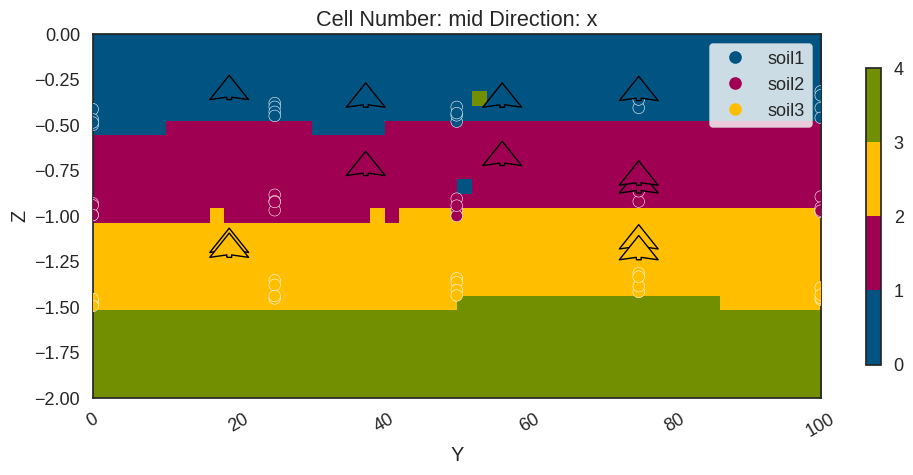

In [27]:
gpv.plot_2d(geo_data, direction=['x'],ve=25, show_data=True, show_boundaries=True)

/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/gempy_viewer/API/_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


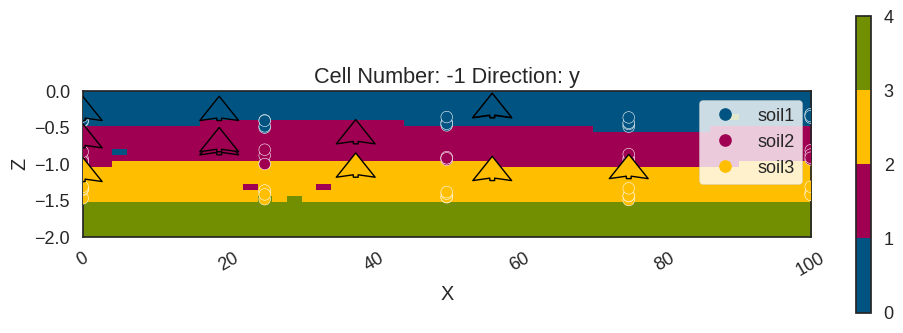

In [28]:
gpv.plot_2d(geo_data, cell_number=[-1], direction=['y'],ve=10, show=True,kwargs_regular_grid={'alpha': .5})

In [29]:
gempy_plot = gpv.plot_3d(
    model=geo_data,
    show_scalar=False,
    ve=10,
    show=False,
    image=False,
    transformed_data=False,
    kwargs_pyvista_bounds={
            'show_xlabels': False,
            'show_ylabels': False,
            'show_zlabels': True,
            'show_xaxis': False,
            'show_yaxis': False,
    },
    kwargs_plot_data={
            'arrow_size': 40.0
    }
)



gempy_plot.p.show()

/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/gempy_viewer/API/_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


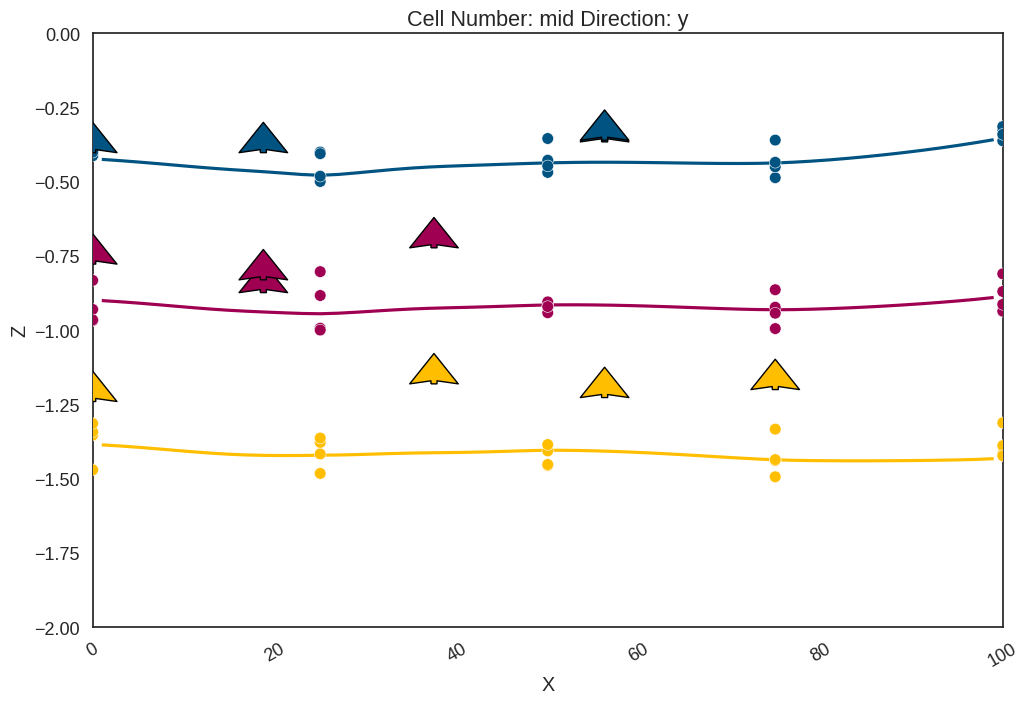

In [30]:
gpv.plot_2d(geo_data, show_value=False, show_lith=False, show_scalar=False,legend=False, cell_number='mid')

-----------------

# The lith block of a computed GemPy model is loaded using NumPy and reshaped to the original dimensions (resolution) of the model.

*The lith block of a GemPy model returns the spatial distribution of layers in the subsurface.*\
*Assuming homogeneous layers and no change in properties with depth, physical properties can easily be assigned to these lithologies.*\
*These could include seismic velocities and densities or thermal conductivities to provide a first estimate of temperatures at depth.*\
Example in https://gemgis.readthedocs.io/en/latest/getting_started/tutorial/51_assigning_physical_properties_to_lith_block.html?highlight=assign_properties

## gemgis.utils.assign_properties(lith_block: numpy.ndarray, property_dict: dict) → numpy.ndarray

Replacing lith block IDs with physical properties

**Parameters:**
- lith_block (np.ndarray) – GemPy lith block array containing the surface IDs
- property_array (dict) – Dict containing the property values mapped to a surface ID

**Returns:**
- property_block – Array containing the properties

**Return type:**
- np.ndarray

In [31]:
lith_block = geo_data.solutions.raw_arrays.lith_block.reshape(grid_reso,grid_reso,int(grid_reso/2))
lith_block.shape

(50, 50, 25)

### Unique values of the array.

In [32]:
density_values,density_index = np.unique(geo_data.solutions.raw_arrays.lith_block,return_index=True) 

In [33]:
density_values[np.argsort(density_index)]

array([4, 3, 2, 1, 5], dtype=int8)

In [34]:
density_values = [np.mean(i) for i in model['densities']]
density_values.append(2.0) # Basement density (g/cm³)

### Sample values are stored as list and will then be converted to to a dictionary.

In [35]:
density_dict = {k: v for k,v in zip(np.unique(np.round(lith_block)), density_values)} 
density_dict

{1: 1.6443597589792618, 2: 1.2487972066469881, 3: 1.4560208469864089, 4: 2.0}

### The density block will then be calculated.

In [36]:
density_block = gg.utils.assign_properties(lith_block=lith_block, property_dict=density_dict)
density_block[0]

array([[2.        , 2.        , 2.        , ..., 1.64435976, 1.64435976,
        1.64435976],
       [2.        , 2.        , 2.        , ..., 1.64435976, 1.64435976,
        1.64435976],
       [2.        , 2.        , 2.        , ..., 1.64435976, 1.64435976,
        1.64435976],
       ...,
       [2.        , 2.        , 2.        , ..., 1.64435976, 1.64435976,
        1.64435976],
       [2.        , 2.        , 2.        , ..., 1.64435976, 1.64435976,
        1.64435976],
       [2.        , 2.        , 2.        , ..., 1.64435976, 1.64435976,
        1.64435976]])

In [37]:
density_block.shape

(50, 50, 25)

### The result can then be plotted with PyVista by creating a new Plotter and adding the lines as mesh.

In [38]:
np.save(data_path+'density_block.npy', density_block)

In [39]:
volume = pv.wrap(density_block)

In [40]:
volume.save(data_path+'density_block.vtk',binary=True)

## The result can be plotted:

In [41]:
folder_input = 'OUTPUT/'+folder_model_name
pyvista_create_gif(folder_input)

# **3D soil model**

In [42]:
img_src = folder_input+'/FIGURES/block_soil_model.gif'
html_code = f'<img src="{img_src}" width="750" align="center">'

In [43]:
display(HTML(html_code))